# __Compte rendu BE AML__

Authors : Tom BOISSE & Jules ESPINOUX

## __Description des données__

Le jeu de données "Gungor 2018 Victorian Author Attribution" est un fichier CSV à deux colonnes :<br>
- La première comprend des extraits de 1000 mots d’auteurs anglais du 19ème siècle (ayant écrit au moins 5 livres). Les 500 mots les plus et moins fréquents, les noms de livres et certains termes spécifiques ont été retirés. Après sélection des 10 000 mots les plus courants et adaptation des phrases en conservant la syntaxe, on obtient plus de 53 000 lignes de 1000 mots, normalisées et sans ponctuation. Chaque phrase a été normalisée et toute ponctuation a été enlevée.<br>
- La deuxième colonne contient l’identifiant de l’auteur, numéro de 1 à 50.<br>
Dans la suite, une "phrase" désigne une ligne de 1000 mots ; "corpus" désigne l’ensemble des phrases. 

## __Objectifs et plan d'action__

L'objectif de ce corpus de textes est d'être capable de prédire quel auteur a écrit une ligne qu'on donnerait en entrée.<br>
Nous avons remarqué que nos données d'entraînement sont standardisées donc nous n'avons pas de prétraitement à faire. Notre problème est une classification supervisée à 50 classes. Ce problème simple en apparence a ici une grande complexité liée à la forme des entrées. En effet, le texte est une entrée compliquée à gérer car il y a des notions de relations entre chaque élément du texte. Ceci s'explique grâce aux différentes régles de grammaire et de conjugaison. Si nous voulons obtenir le maximum de précision il faudra chercher un moyen de transformer nos textes en entréee valides pour des classifieurs tout en essayant de garder ces éléments de relations. <br>

#### Transformation des entrées

Cette étape est cruciale pour la suite, nous avons deux pistes que nous aimerons tester. La première est le Bag of Words (BoW) et la seconde est le TF-IDF. Ces deux pistes se nomment des vectorizers car elles transforment une phrase qui est une liste de mots en un vecteur de nombre plus digeste pour des algorithmes de machine learning. <br>
L'idée de la première prendre l'entièreté du corpus, de trier chaque mot par rapport à sa fréquence d'apparition pour ensuite transformer chaque phrase en vecteur de taille 10 000 (nombre de mots différents dans notre corpus) où la donnée à l'indice i représente le nombre d'occurence dans notre phrase du ième mot le plus récurent dans notre corpus. Ainsi, si "the" est le 4ème le plus courant dans tout notre corpus et que dans notre phrase il apparait 5 fois alors après transformation de notre phrase, à l'indice 4 nous retrouverons le nombre 5.
<br>
La seconde piste est un acronyme pour Text Frequency - Inverse document frequency. Nous précalculons la IDF qui est un vecteur représentant, pour chaque mot, l'inverse de sa fréquence d'apparition dans tout le corpus. Et pour chaque phrase, quand nous voulons la transformer, nous calculons sa TF qui est la fréquence d'apparition du mot dans cette phrase. Ainsi, si nous avons "cat cat dog" et que cat apprait 5 fois dans tout le corpus et dog 9 fois, quand nous transformerons la phrase, nous obtiendrons [2/5, 2/5, 1/9]. 

#### Classification des données

Nous devons essayer de trouver une méthode qui a un bon potentiel pour apprendre à classer chaque phrase grâce à son label avec plus que 2 classes. Deux algorithmes sortent du lot pour cette tâche précise, ce sont le Naïve Bayes et le SVM. Nous allons donc dans un premier temps tester ces algorithmes avec un split de notre jeu de données pour estimer le potentiel de chaque méthode puis ensuite nous essayerons d'affiner les hyperparamètres pour améliorer la précision de notre modèle.

## __Transformation de nos données__

Nous allons donc appliquer ce que nous avons définit plus tôt. Nous faisons le choix d'entraîner nos deux vectorizers sur notre corpus et pas juste sur le sous ensemble d'entraînement car ceci améliore la précision des vectorizers sans impacter la transformation des données.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# loading the csv file, separate data and labels and then split
df_train = pd.read_csv("dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv", sep=",", encoding='latin-1')
X_total = df_train["text"].values
y_total = df_train["author"].values
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer # bow vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf vectorizer

In [ ]:
# creating bow vectorizer + train with total data set
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(X_total)

In [ ]:
    X_train_bow = bow_vectorizer.transform(X_train)
    X_test_bow = bow_vectorizer.transform(X_test)

In [8]:
# creating tf idf vectorizer + train with total data set
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_total)

TfidfVectorizer()

In [9]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## __Classification des données__

Nous allons donc essayer notre 4 combinaisons. Nos deux vectorizers avec Naïve Bayes et nos deux vectorizers avec SVM.

In [10]:
from sklearn.naive_bayes import MultinomialNB # naives bayes classifier
from sklearn.svm import LinearSVC # svm classifier
from sklearn.metrics import accuracy_score # compute accuracy scores

### Naive Bayes 

In [ ]:
# nb_model = MultinomialNB() # naive bayes model
nb_model.fit(X_train_bow, y_train)
y_nb_bow = nb_model.predict(X_test_bow)
print(f"*-* Accuracy for BoW and Naive Bayes :  {accuracy_score(y_test, y_nb_bow):.3f}")

In [12]:
nb_model = MultinomialNB() # naive bayes model
nb_model.fit(X_train_tfidf, y_train)
y_nb_tfidf = nb_model.predict(X_test_tfidf)  # BUG FIX: was svm_model
print(f"*-* Accuracy for TFIDF and Naive Bayes :  {accuracy_score(y_test, y_nb_tfidf):.3f}")

*-* Accuracy for TFIDF and Naive Bayes :  0.508


### SVM

In [ ]:
# svm_model = LinearSVC(C=1) # svm model
svm_model.fit(X_train_bow, y_train)
y_svm_bow = svm_model.predict(X_test_bow)
print(f"*-* Accuracy for BoW and SVM :  {accuracy_score(y_test, y_svm_bow):.3f}")

In [14]:
svm_model = LinearSVC(C=1) # svm model
svm_model.fit(X_train_tfidf, y_train)
y_svm_tfidf = svm_model.predict(X_test_tfidf)
print(f"*-* Accuracy for TFIDF and SVM :  {accuracy_score(y_test, y_svm_tfidf):.3f}")

*-* Accuracy for TFIDF and SVM :  0.979


## __Affinement du modèle__

Après une première série de test, nous concluons que BoW joue sur la performance du modèle, il est bien moins performant que TFIDF. On choisit de faire jouer les paramètres des modèles naive bayes et SVM pour en sortir un principal.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

param_grid_nb = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, 
                              scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_nb.fit(X_train_tfidf, y_train)

alpha_values = [params['alpha'] for params in grid_search_nb.cv_results_['params']]
mean_scores_nb = grid_search_nb.cv_results_['mean_test_score']
std_scores_nb = grid_search_nb.cv_results_['std_test_score']

print(f"Optimal alpha: {grid_search_nb.best_params_['alpha']}")
print(f"CV accuracy: {grid_search_nb.best_score_:.4f}")
print(f"Test accuracy: {grid_search_nb.score(X_test_tfidf, y_test):.4f}")


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Optimal alpha: 0.01
CV accuracy: 0.8269
Test accuracy: 0.8337


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_search = GridSearchCV(LinearSVC(max_iter=10000), param_grid, cv=5, 
                           scoring='accuracy', n_jobs=-1, verbose=1)

# Fit and find best C
grid_search.fit(X_train_tfidf, y_train)

# Extract results
C_values = [params['C'] for params in grid_search.cv_results_['params']]
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

print(f"Optimal C: {grid_search.best_params_['C']}")
print(f"CV accuracy: {grid_search.best_score_:.4f}")
print(f"Test accuracy: {grid_search.score(X_test_tfidf, y_test):.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

On voit que le paramètre C optimal vaut 5 et qu'on a une précision améliorée à 0.98. Le modèle reste très performant. 
On pourrait chercher à affiner encore plus le modèle mais le temps d'éxécution élevé, on choisit par confort de rester avec ce modèle déjà très performant.

## __Interprétabilité du modèle SVM__


On considère par la suite que le modèle SVM optimal, soit avec C=5 comme trouvé précédemment. Le SVM est réputé pour être difficilement interprétable, on va chercher à extraire des informations à partir des résultats du modèle.

In [ ]:
best_svm = LinearSVC(C=5, max_iter=10000)
best_svm.fit(X_train_tfidf, y_train)
feature_names = tfidf_vectorizer.get_feature_names_out()

### 1. Top mots discriminants par auteur


Visualisation des poids SVM les plus discriminants (en valeur absolue) pour 3 auteurs. Les poids positifs (vert) favorisent la classification vers l'auteur, les négatifs (rouge) discriminent contre.


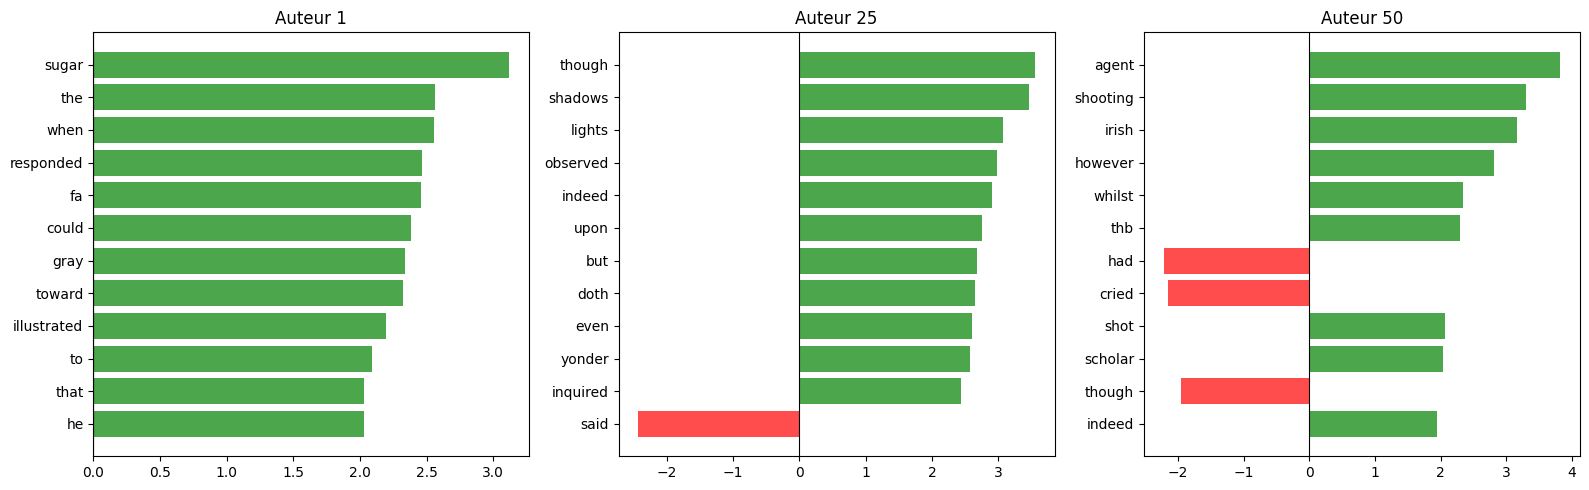

In [34]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
classes_in_train = np.unique(y_train)
selected_idx = [0, len(classes_in_train)//2, -1]

for i, idx in enumerate(selected_idx):
    author = classes_in_train[idx]
    coefs = best_svm.coef_[idx]
    top_idx = np.argsort(np.abs(coefs))[-12:][::-1]
    
    words = [feature_names[j] for j in top_idx]
    weights = [coefs[j] for j in top_idx]
    colors = ['green' if w > 0 else 'red' for w in weights]
    
    axes[i].barh(words, weights, color=colors, alpha=0.7)
    axes[i].set_title(f'Auteur {author}')
    axes[i].axvline(0, color='black', linewidth=0.8)
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()


On peut s'intéresser aux auteurs qui utilisent un lexique bien spécifique. Pour cela on va considérer pour chaque auteur, le poids maximal atteint par un feature. Ce poids nous indiquera à quel point le lexique employé par l'auteur joue sur son attribution des différentes phrases.

In [ ]:
# Poids max par auteur (mesure du vocabulaire distinctif)
classes_in_train = np.unique(y_train)
max_weights = [np.max(best_svm.coef_[i]) for i in range(len(classes_in_train))]

print(f"Poids max moyen: {np.mean(max_weights):.3f} ± {np.std(max_weights):.3f}")
print(f"\nTop 5 auteurs les plus distinctifs:")
for i in np.argsort(max_weights)[-5:][::-1]:
    print(f"  Auteur {classes_in_train[i]}: {max_weights[i]:.3f}")



Statistiques globales (45 auteurs présents dans le dataset de train):
Poids positif max moyen : 3.9315 ± 1.1213
Poids négatif min moyen : -2.4620 ± 0.7382

Auteurs avec vocabulaire le plus distinctif:
  Auteur 45: poids max = 7.5429
  Auteur 4: poids max = 6.6215
  Auteur 21: poids max = 5.7656
  Auteur 3: poids max = 5.5878
  Auteur 8: poids max = 5.4596
